# Self-Driving Car Engineer Nanodegree
## Project: Advance Lane Lines Finding

## Import Packages

In [1]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


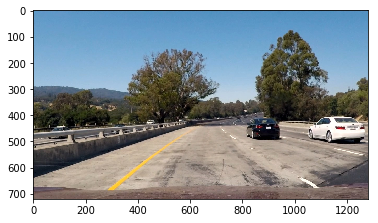

In [2]:
#reading in an image
image = mpimg.imread('test_images/test1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Function

Build your pipeline to work on the images in the directory "test_images"
You should make sure your pipeline works well on these images before you try the videos.

### compute the camera calibration using chessboard images

In [3]:
def find_camera_distortion_mapping(src):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(src + '/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        row = i // 3
        col = i % 3
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    return objpoints, imgpoints

### Apply a distortion correction to raw images

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Use color transforms, gradients, etc., to create a thresholded binary image

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, guassian_blur=7):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (guassian_blur, guassian_blur), 0)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    sobelx = (cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = (cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    mag_sobel = np.arctan2(sobely, sobelx)
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(mag_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(mag_sobel >= thresh[0]) & (mag_sobel <= thresh[1])] = 1

    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_output

In [18]:
def yellow_color(img, dilate=1):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20,60,60])
    upper_yellow = np.array([80,255,255])
    
    kernel = np.ones((dilate,dilate), np.uint8)

    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask[mask > 0] = 1
    
    return mask

In [19]:
def white_color(img, level = 235, dilate=1):
    kernel = np.ones((dilate,dilate), np.uint8)
    
    mask = cv2.inRange(img, (level, level, level), (255, 255, 255))
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask[mask > 0] = 1
    
    return mask

In [20]:
def black_color(img, level = 40, dilate=1):
    kernel = np.ones((dilate,dilate), np.uint8)
    
    mask = cv2.inRange(img, (0, 0, 0), (level, level, level))
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask[mask > 0] = 1
    
    return mask

### Apply a perspective transform to rectify binary image ("birds-eye view")

In [7]:
def transformToBirdEye(img, src, dst):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img.shape[1::-1])
    
    return warped, M

### Detect lane pixels and fit to find the lane boundary.

In [8]:
from scipy.stats import norm

def birdview_pixel_weighting(shape, left_lane, right_lane, y_dist_max, y_dist_w, sigma=100):
    result = np.ones(shape)

    x_left = norm(loc = left_lane, scale = sigma)
    x_right = norm(loc = right_lane, scale = sigma)
    x_idx = np.arange(0, shape[0], 1) 
    x = (x_left.pdf(x_idx) + x_right.pdf(x_idx)) / (0.3989/sigma) * 4
    y = np.append(np.zeros(y_dist_max), np.linspace(1, y_dist_w, shape[1] - y_dist_max))
    xv, yv = np.meshgrid(x, y)
    result = xv * yv

    np.clip(result, 0, 255, out=result)
    return result.astype(np.uint8)

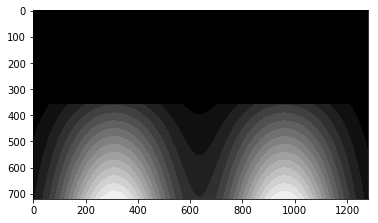

In [9]:
shape = (1280, 720)
mask = birdview_pixel_weighting(shape, 310, 960, shape[1]//2, 4,150)
plt.imshow(mask, cmap='gray')
#print(mask)

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def draw_histogram(binary_warped):
    shape = binary_warped.shape[1::-1]
    fig = Figure(figsize=(3,1))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    weights = birdview_pixel_weighting(shape, 310, 960, shape[1]//2, 4,150)
    weighted_binary_warped = weights * binary_warped 
    histogram = np.sum(weighted_binary_warped[weighted_binary_warped.shape[0]//2:,:], axis=0)
    
    ax.plot(histogram)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    canvas.draw()       # draw the canvas, cache the renderer

    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    
    return image

def find_left_and_right_lane(binary_warped):
    shape = binary_warped.shape[1::-1]
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    weights = birdview_pixel_weighting(shape, 310, 960, shape[1]//2, 4,150)
    weighted_binary_warped = weights * binary_warped 
    histogram = np.sum(weighted_binary_warped[weighted_binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 27
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    leftw = (lefty / binary_warped.shape[0]) ** 3
    rightw = (righty / binary_warped.shape[0]) ** 3
    
    #print('debug', leftw, rightw)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2, w=leftw)
    right_fit = np.polyfit(righty, rightx, 2, w=rightw)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

# Generate x and y values for plotting
def plot_left_and_right_lane(out_img, binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    out_img = cv2.polylines(out_img, np.int_([pts_left]), False, (255,255, 0), thickness=3)
    
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    out_img = cv2.polylines(out_img, np.int_([pts_right]), False, (255,255, 0), thickness=3)
    
    return out_img
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [11]:
def find_real_scale_left_and_right_lane(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.zeros(left_fit.shape)
    right_fit_cr = np.zeros(right_fit.shape)
    
    left_fit_cr[0] = left_fit[0] / ym_per_pix / ym_per_pix * xm_per_pix
    left_fit_cr[1] = left_fit[1] / ym_per_pix * xm_per_pix
    left_fit_cr[2] = left_fit[2] * xm_per_pix
    
    right_fit_cr[0] = right_fit[0] / ym_per_pix / ym_per_pix * xm_per_pix
    right_fit_cr[1] = right_fit[1] / ym_per_pix * xm_per_pix
    right_fit_cr[2] = right_fit[2] * xm_per_pix
                            
    return left_fit_cr, right_fit_cr

In [12]:
def find_curvature(image_shape, left_fit_cr, right_fit_cr):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = image_shape[0]  # bottom of the image

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad  # in meter

In [13]:
def find_off_center(image_shape, left_fit_cr, right_fit_cr):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = image_shape[0] * ym_per_pix
    
    left_fit_base = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_fit_base = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    
    lane_width = image_shape[1] * xm_per_pix
    
    off_center  = (right_fit_base + left_fit_base)/2- lane_width/2
    
    return off_center

In [14]:
def create_final_image(undist, Minv, warped, left_fit, right_fit, left_lane_inds=None, right_lane_inds=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    if (not(left_lane_inds is None or right_lane_inds is None)):
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    return result

In [15]:
def add_driving_info(image, left_curve, right_curve, off_center):
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature = 0.5*(left_curve + right_curve)
    cv2.putText(image, "Radius of curvature = %.2f(m)" % curvature,(10,30), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image, "Vehicle is %.2fm left of center" % off_center ,(10,60), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return image

In [16]:
src = np.array([[(189,720),
                    (590,450), 
                    (689,450), 
                    (1135,720)
                ]], dtype=np.float32)
    
dst = np.array([[(315,720),
                (315,0), 
                (960,0), 
                (960,720)
            ]], dtype=np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

objpoints, imgpoints = find_camera_distortion_mapping("camera_cal")

image_shape = (1280,720)

ret, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)

### Color constancy

In [17]:
def approx_g(image, sigma_g, n=5):
    w = np.sqrt(12*sigma_g**2/n + 1)
    wu = np.ceil(w) if np.ceil(w) % 2 == 1 else np.ceil(w)+1
    wl = np.floor(w) if np.floor(w) % 2 == 1 else np.floor(w)-1
    if w == w//1:
        wl -= 2
        wu += 2
    m = round((12*sigma_g**2 - n*wl**2 - 4*n*wl - 3*n) / (-4*wl - 4))
    wl = int(wl)
    wu = int(wu)
    for num in range(0,int(m)):
        image = cv2.blur(image, (wl, wl))
    for num in range(0,int(n-m)):
        image = cv2.blur(image, (wu, wu))
    return image

def singleScaleRetinex(img, sigma):
    #retinex = np.log10(img) - np.log10(GaussianBlur(img, sigma))
    retinex = np.log10(img) - np.log10(approx_g(img, sigma))
    
    return retinex

def multiScaleRetinex(img, sigma_list):

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        retinex += singleScaleRetinex(img, sigma)

    retinex = retinex / len(sigma_list)

    return retinex

def automatedMSRCR(img, sigma_list):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)

    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break
            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break
            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255
    
    img_retinex = np.uint8(img_retinex)
        
    return img_retinex

### Histogram equalization

In [22]:
def equalizeIntensity(img):
    if(img.shape[2] >= 3):
        ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb);
        
        channels = cv2.split(ycrcb)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        channels[0] = clahe.apply(channels[0])
        
        ycrcb = cv2.merge(channels);

        result = cv2.cvtColor(ycrcb,cv2.COLOR_YCrCb2BGR);

        return result;
    return img

In [23]:
def intensity_statistic(img):
    if(img.shape[2] >= 3):
        ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb);
        channels = cv2.split(ycrcb)
        
        return np.min(channels[0]), np.max(channels[0]), np.mean(channels[0]), np.std(channels[0])
    return img

### Final Image pipeline

In [21]:
def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

In [24]:
import os

t_images = glob.glob('./test_images/*.jpg')

for i, fname in enumerate(t_images):
    
    img = np.array(Image.open(fname))
    
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_undist_enhanced_part = equalizeIntensity(img_undist[450:, :, :])
    img_undist_enhanced = np.copy(img_undist)
    img_undist_enhanced[450:, :, :] = img_undist_enhanced_part
    
    y_binary = yellow_color(img_undist_enhanced, 9)
    w_binary = white_color(img_undist_enhanced, 210, 9)
    b_binary = black_color(img_undist_enhanced)
    mask_clr = np.zeros_like(y_binary)
    mask_clr[(b_binary ==0) & ((y_binary == 1) | (w_binary == 1))] = 1
    color_mask_clr = np.dstack(( np.zeros_like(y_binary), y_binary, w_binary)) * 255
    
    sxbinary = abs_sobel_thresh(img_undist_enhanced, 'x', 20, 100) #[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_binary = hls_select(img_undist_enhanced, (170, 255)) #[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    s_white = white_color(img_undist_enhanced)
    color_binary = np.dstack((sxbinary, s_binary, s_white)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    #combined_binary[((s_binary == 1) | (sxbinary == 1))] = 1
    combined_binary[(mask_clr == 1) & ((s_binary == 1) | (sxbinary == 1) | (s_white == 1))] = 1
    
    img_birdview_bin = cv2.warpPerspective(combined_binary, M, combined_binary.shape[1::-1])
    
    left_fit, right_fit, left_lane_inds, right_lane_inds = find_left_and_right_lane(img_birdview_bin)
    
    # create bird eye lane image
    img_birdview_clr = cv2.warpPerspective(img_undist, M, combined_binary.shape[1::-1])
    img_birdview_lane = plot_left_and_right_lane(img_birdview_clr, img_birdview_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    image_shape = img_birdview_bin.shape
    left_fit_cr, right_fit_cr = find_real_scale_left_and_right_lane(left_fit, right_fit)
    left_curve, right_curve = find_curvature(image_shape, left_fit_cr, right_fit_cr)
    
    off_center = find_off_center(image_shape, left_fit_cr, right_fit_cr)
    image = create_final_image(img_undist, Minv, img_birdview_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
    image = add_driving_info(image, left_curve, right_curve, off_center)
    
    # create debug image
    img_hist= draw_histogram(img_birdview_bin)
    img_hist = Image.fromarray(cv2.resize(img_hist, (img.shape[1]//2, img.shape[0]//6), interpolation = cv2.INTER_CUBIC))
    img_hist = img_hist.convert('RGBA')
    img_hist.putalpha(128)

    debug_im = Image.new('RGB', (img.shape[1] * 3 //2 , img.shape[0] * 3 //2))
    debug_im.paste(Image.fromarray(image), (0, 0)) 
    debug_im.paste(Image.fromarray(cv2.resize(img_undist_enhanced, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (0, img.shape[0]))
    debug_im.paste(Image.fromarray(cv2.resize(img_birdview_bin*255, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (img.shape[1]//2, img.shape[0]))
    debug_im.paste(Image.fromarray(cv2.resize(color_mask_clr, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (img.shape[1], 0))
    debug_im.paste(Image.fromarray(cv2.resize(color_binary, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (img.shape[1], img.shape[0]//2))
    debug_im.paste(Image.fromarray(cv2.resize(img_birdview_lane, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (img.shape[1], img.shape[0]))
    debug_im.paste(img_hist, (img.shape[1]//2, img.shape[0]+img.shape[0]//3), img_hist)
    plt.imsave(os.path.join('./output_images', os.path.basename(fname)), image)
    debug_im.save(os.path.join('./output_images', "debug_"+os.path.basename(fname)))

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the test_images_output directory, and you can use the images in your writeup report.
Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

solidWhiteRight.mp4

solidYellowLeft.mp4

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def find_left_and_right_lane_shortcut(binary_warped, left_fit, right_fit):

    if(left_fit is None or right_fit is None):
        return find_left_and_right_lane(binary_warped)
    
    #print('debug', left_fit, right_fit)
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1] * nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    leftw = (leftx / binary_warped.shape[0]) ** 3
    rightw = (rightx / binary_warped.shape[0]) ** 3
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2, w=leftw)
    right_fit = np.polyfit(righty, rightx, 2, w=rightw)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [ ]:
def image_pipeline(img_input, left_fit, right_fit):
    
    img_undist = cv2.undistort(img_input, mtx, dist, None, mtx)

    #lower-half enhancement
    lower_half_start_y = 450
    near_car_start_y = 600
    
    img_undist_enhanced_part = equalizeIntensity(img_undist[lower_half_start_y:, :, :])
    img_undist_enhanced = np.copy(img_undist)
    img_undist_enhanced[lower_half_start_y:, :, :] = img_undist_enhanced_part

    #color masking
    per_color_mask_low = 0.05 
    per_color_mask_low_near_car = 0.02 
    
    y_binary = yellow_color(img_undist_enhanced, 9)
    w_binary = white_color(img_undist_enhanced, 210, 9)
    b_binary = black_color(img_undist_enhanced)
    mask_clr = np.zeros_like(y_binary)
    mask_clr[(b_binary ==0) & ((y_binary == 1) | (w_binary == 1))] = 1
    color_mask_clr = np.dstack(( np.zeros_like(y_binary), y_binary, w_binary)) * 255
    
    if(sum(sum(mask_clr[lower_half_start_y:, :])) 
       < (img_input.shape[0]-lower_half_start_y)*img_input.shape[1]*per_color_mask_low 
      or 
       sum(sum(mask_clr[near_car_start_y:, :])) 
       < (img_input.shape[0]-near_car_start_y)*img_input.shape[1]*per_color_mask_low_near_car 
      ):
        img_undist_enhanced_part = automatedMSRCR(img_undist[lower_half_start_y:, :, :], [15,80,250])
        img_undist_enhanced = np.copy(img_undist)
        img_undist_enhanced[lower_half_start_y:, :, :] = img_undist_enhanced_part
        
        y_binary = yellow_color(img_undist_enhanced, 9)
        w_binary = white_color(img_undist_enhanced, 210, 9)
        b_binary = black_color(img_undist_enhanced)
        mask_clr = np.zeros_like(y_binary)
        mask_clr[(b_binary ==0) & ((y_binary == 1) | (w_binary == 1))] = 1
        color_mask_clr = np.dstack(( np.zeros_like(y_binary), y_binary, w_binary)) * 255

    sxbinary = abs_sobel_thresh(img_undist_enhanced, 'x', 20, 100) #[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_binary = hls_select(img_undist_enhanced, (170, 255)) #[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    s_white = white_color(img_undist_enhanced)
    color_binary = np.dstack(( sxbinary, s_binary, s_white)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    #combined_binary[((s_binary == 1) | (sxbinary == 1))] = 1
    combined_binary[(mask_clr == 1) & ((s_binary == 1) | (sxbinary == 1) | (s_white == 1))] = 1

    img_birdview_bin = cv2.warpPerspective(combined_binary, M, combined_binary.shape[1::-1])

    left_fit, right_fit, left_lane_inds, right_lane_inds = find_left_and_right_lane(img_birdview_bin)

    # create bird eye lane image
    img_birdview_clr = cv2.warpPerspective(img_undist, M, combined_binary.shape[1::-1])
    img_birdview_lane = plot_left_and_right_lane(img_birdview_clr, img_birdview_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

    image_shape = img_birdview_bin.shape
    left_fit_cr, right_fit_cr = find_real_scale_left_and_right_lane(left_fit, right_fit)
    left_curve, right_curve = find_curvature(image_shape, left_fit_cr, right_fit_cr)

    off_center = find_off_center(image_shape, left_fit_cr, right_fit_cr)
    image = create_final_image(img_undist, Minv, img_birdview_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
    image = add_driving_info(image, left_curve, right_curve, off_center)

    # create debug image
    img_hist= draw_histogram(img_birdview_bin)
    img_hist = Image.fromarray(cv2.resize(img_hist, (img.shape[1]//2, img.shape[0]//6), interpolation = cv2.INTER_CUBIC))
    img_hist = img_hist.convert('RGBA')
    img_hist.putalpha(128)

    debug_im = Image.new('RGB', (img.shape[1] * 3 //2 , img.shape[0] * 3 //2))
    debug_im.paste(Image.fromarray(image), (0, 0)) 
    debug_im.paste(Image.fromarray(cv2.resize(img_undist_enhanced, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (0, img.shape[0]))
    debug_im.paste(Image.fromarray(cv2.resize(img_birdview_bin*255, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)).convert('RGB'), (img.shape[1]//2, img.shape[0]))
    debug_im.paste(Image.fromarray(cv2.resize(color_mask_clr, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (img.shape[1], 0))
    debug_im.paste(Image.fromarray(cv2.resize(color_binary, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (img.shape[1], img.shape[0]//2))
    debug_im.paste(Image.fromarray(cv2.resize(img_birdview_lane, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)), (img.shape[1], img.shape[0]))
    debug_im.paste(img_hist, (img.shape[1]//2, img.shape[0]+img.shape[0]//3), img_hist)
    
    return  np.array(debug_im), left_fit, right_fit

In [ ]:
left_fit = None
right_fit = None

import traceback

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global left_fit
    global right_fit
    
    try:
        result, left_fit, right_fit = image_pipeline(image, left_fit, right_fit)
    except Exception as ex:
        mpimg.imsave("error_images/error.jpg", image)
        traceback.print_exc()  
        return image
            
    return result

In [ ]:
if not (os.path.isdir("output_videos")):
    os.mkdir("output_videos")

white_output = os.path.join('./output_videos/', 'project_video.mp4')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
previous_lane = None
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
clip2 = VideoFileClip("challenge_video.mp4")
left_fit = None
right_fit = None
challenge_output = os.path.join('./output_videos/', 'challenge_video.mp4')

challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
clip3 = VideoFileClip("harder_challenge_video.mp4")
left_fit = None
right_fit = None
harder_challenge_output = os.path.join('./output_videos/', 'harder_challenge_video.mp4')

harder_challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))